# Convolutional Neural Networks Demo

## Hand-written digit classification with convolutional neural networks

In this demo, we will show how to build a convolutional neural networks for hand-written digit classification. We will use MNIST as the dataset.

In [1]:
import torch
import torchvision

Set random seed

In [2]:
random_seed = 9999
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Load the dataset using Pytorch API. First we load the training set. The training set contains 60000 images and the test set contains 10000 images. 

In [3]:
batch_size_train = 64
batch_size_test = 1000


trainset = torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(trainset))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

60000


In [4]:
testset = torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(testset))

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True)

10000


Let's show some example images.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

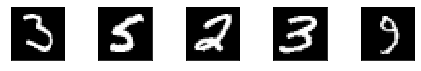

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's build a convolutional neural network (CNN) with Pytorch. In this demo, we build a LeNet-like convolutional neural network.

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return F.log_softmax(y)

In [9]:
network = CNN()

#
print (network)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)


For training the network, we need to specify the optimizer. 

In [10]:
n_epochs = 10
learning_rate = 0.01
momentum = 0.9
log_interval = 10

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [11]:
train_losses = []
test_losses = []

In [12]:
def train(epoch):
  network.train()
   
  train_loss = 0

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    
    output = network(data)
    loss = F.nll_loss(output, target)
    
    train_loss += loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    
  
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)
        

In [13]:
def test():
  network.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
for epoch in range(1, n_epochs + 1):
  
  train(epoch)
  test()

/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305847
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305976
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293512
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.266896
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.275547
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.251894
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.200465
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.180280
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.875957
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.831398
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.352021
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.420869
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.222429
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.052010
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.941905
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.802751
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.972403
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.996732
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.838029
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.800605
Train Epoch: 1 [12800/60000 (

/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0591, Accuracy: 9815/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.055578
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.084668
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.201046
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.181355
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.014325
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.039115
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.095788
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.043468
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.040865
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.035970
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.074925
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.064337
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.048477
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.232246
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.097910
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.138614
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.050940
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.122982
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.020022
Train Epoch: 2 [12160

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.081261
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.043705
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.019956
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.013281
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.009919
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.004667
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.047890
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.003100
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.106849
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.065596
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.022606
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.020438
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.029711
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.038800
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.109081
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.124377
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.034435
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.003665
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.059225
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.030098


Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.000621
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.029039
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.019613
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.011123
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.111283
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.092748
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.294645
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.038194
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.003316
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.013902
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.014347
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.029614
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.000887
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.006633
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.053783
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.203209
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.044636
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.004071
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.008292
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.011789


Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.012264
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.021894
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.029812
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.028452
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.031699
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.003681
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.001780
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.013492
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.015646
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.000909
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.007987
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.009458
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.142578
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.001646
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.002627
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.001660
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.005783
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.005346
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.027005
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.002098


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.039958
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.000757
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.000315
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.003817

Test set: Avg. loss: 0.0351, Accuracy: 9894/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001203
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.001702
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.006835
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.003360
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.020107
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.114815
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.027489
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.003741
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.024776
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.000524
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000546
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.019681
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.005357
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.000982
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.009459
Train Epoch: 9 [9600

Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.029844
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.003413
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.001004
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.001284
Train Epoch: 10 [43520/60000 (72%)]	Loss: 0.008435
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.000366
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.003186
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.031276
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.007551
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.004646
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.001402
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.008663
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.027820
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.002759
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.008343
Train Epoch: 10 [50560/60000 (84%)]	Loss: 0.076657
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.111776
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.125800
Train Epoch: 10 [52480/60000 (87%)]	Loss: 0.020978
Train Epoch: 10 [53120/60000 (8

Text(0, 0.5, 'negative log likelihood loss')

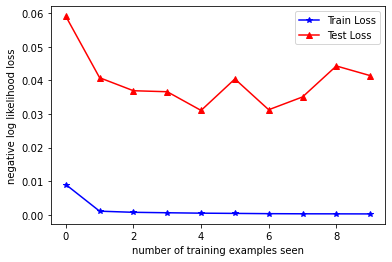

In [15]:
fig = plt.figure()
plt.plot(train_losses, "-*", color='blue')
plt.plot(test_losses, "-^", color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [16]:
with torch.no_grad():
  output = network(example_data)

/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


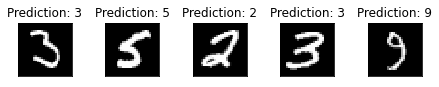

In [17]:
fig = plt.figure()
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])


Let's show some examples that the network make wrong predictons.

/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


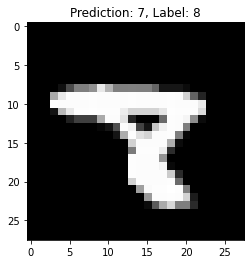

In [19]:
fig = plt.figure()
plt.tight_layout()

for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1].numpy()
      
      cnt = len(pred)
      for i in range(cnt):
            if pred[i].item() != target[i].item():
                
                plt.imshow(data[i][0], cmap='gray', interpolation='none')
                plt.title("Prediction: {}, Label: {}".format(pred[i].item(), target[i].item()))
                break
      break

plt.show()